In [1]:
#import all the required packages
#submitted by - Rakavee Anandan ra2635
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
#define all required functions
#function for convolution
#inputs: image and con_factor - convolution factor
def convolve_np(image, con_factor, height, width):
    #image height and width
    image_height = image.shape[0]
    image_width = image.shape[1]
    #convolution factor height and width
    con_factor_height = con_factor.shape[0]
    con_factor_width = con_factor.shape[1]
    #determine from which pixel we need to do convolution, because depending on the convolution factor, there will be undefined rows and columns.
    H = (int((con_factor_height - 1) / 2))
    W = (int((con_factor_width - 1) / 2))
    #initialize output image to return
    out = np.zeros((image_height, image_width))
    #convolution excluding undefined pixel values
    for i in np.arange(H + height, image_height - (H + height)):
        for j in np.arange(W + width, image_width- (W + width)):
            sum = 0
            for k in np.arange(-H, H+1):
                for l in np.arange(-W, W+1):
                    a = image[i+k, j+l]
                    f = con_factor[H+k, W+l]
                    sum = sum + (f * a)
            out[i][j] = sum
        
    return out #return the output image

In [3]:
#function to determine whether or not the value is a local maximum
#args - edge magnitude value, current indeces i and j to fetch the neighbours, Gradient values gx and gy
def local_max(edge_magnitude, i, j, gx, gy, t):
#find the orientation sector using tan inverse of gx/gy
    sector = -1
    if gx != 0 and gy != 0:
        theta = (np.arctan2(gy,gx) / np.pi) * 180 
        if theta < 0:
            theta += 360
        #sector 0
        if (theta > 337.5 and theta <=360) or (theta >= 0 and theta <= 22.5) or (theta > 157.5 and theta <= 202.5):
            sector = 0
        #sector 1
        elif (theta > 22.5 and theta <=67.5) or (theta > 202.5 and theta <= 247.5):
            sector = 1
        #sector 2
        elif (theta > 67.5 and theta <=112.5) or (theta > 247.5 and theta <= 292.5):
            sector = 2
        #sector 3
        elif (theta > 112.5 and theta <=157.5) or (theta > 292.5 and theta <= 337.5):
            sector = 3
            
    #check for local maximum
    center = edge_magnitude[i,j]
    if center < t:
        return False
    else:
        #identify the left neighbour
        left = -1
        if sector == 0:
            left = edge_magnitude[i, j-1]
        elif sector == 1:
            left = edge_magnitude[i-1, j+1]
        elif sector == 2:
            left = edge_magnitude[i-1, j]
        elif sector == 3:
            left = edge_magnitude[i-1, j-1]        
        #identify the right neighbour
        right = -1
        if sector == 0:
            right = edge_magnitude[i, j+1]
        elif sector == 1:
            right = edge_magnitude[i+1, j-1]
        elif sector == 2:
            right = edge_magnitude[i+1, j]
        elif sector == 3:
            right = edge_magnitude[i+1, j+1]
        #return the truth value whether or not the value is local maximum
    return center >= left and center >= right

In [4]:
#function to implement gaussian filter on the image 
#args - input image array
def gaussian_filter(input_image):
    #initialize the convolution factor for gaussian filter - normailsed when divided by sum of the elements 140
    gauss = [1.0/140] * np.array(
        [
            [1,1,2,2,2,1,1],
            [1,2,2,4,2,2,1],
            [2,2,4,8,4,2,2],
            [2,4,8,16,8,4,2],
            [2,2,4,8,4,2,2],
            [1,2,2,4,2,2,1],
            [1,1,2,2,2,1,1]
        ])
    #function call to convolve input image and the gaussian filter
    img_out = convolve_np(input_image, gauss, 0 ,0)
    #write the output to file
    cv2.imwrite('gaussian_output.jpg', img_out)
    #return the output array to do the next step - Gradient Calculation
    return img_out

In [5]:
#function to implement gradient calculation for x and y using Prewitt's operator
#args - output array after implementing gaussian filter
def prewitt_gradient(gaussian_output):
    #initialize the convolution factors for the Prewitt's operator
    prewitt_xoperator = np.array(
        [
            [-1,0,1],
            [-1,0,1],
            [-1,0,1]
        ])

    prewitt_yoperator = np.array(
        [
            [1,1,1],
            [0,0,0],
            [-1,-1,-1]
        ])
    #do convolution of the gaussian output with x and y factors separately.
    img_x = convolve_np(gaussian_output, prewitt_xoperator,3,3)
    img_y = convolve_np(gaussian_output, prewitt_yoperator,3,3)
    #find the edge magnitude value
    edge_magnitude = np.sqrt(np.power(img_x, 2) + np.power(img_y, 2))
    #write the outputs to files
    cv2.imwrite('prewittx_output.jpg', img_x)
    cv2.imwrite('prewitty_output.jpg', img_y)
    cv2.imwrite('edgemagnitude_output.jpg', edge_magnitude)
    #return the outputs to do the next step - non maxima suppression
    return img_x, img_y, edge_magnitude

In [6]:
#function to implement non maxima suppression
#args - edge magnitude values, prewitt's x and y gradients, height and width of the image
def nonmaxima_suppresion(edgemagnitude_output,prewittx_output,prewitty_output,height,width):
    t = 5
    #initialize the nms output image
    nms = np.zeros((height, width))
    #make the out of limit rows and columns 0
    for i in range(height):
        edgemagnitude_output[i][4] = 0
    for i in range(width):
        edgemagnitude_output[4][i] = 0
    #find the local maximum for each element and get the non maxima suppressed image
    for i in np.arange(1, height-1):
        for j in np.arange(1, width-1):
            dx = prewittx_output[i,j]
            dy = prewitty_output[i,j]
            if local_max(edgemagnitude_output, i, j, dx, dy, t):
                nms[i,j] = edgemagnitude_output[i,j]
            else:
                nms[i,j] = 0
    #write the output to file
    cv2.imwrite('nms_output.jpg', nms)
    #return the output to do the next step - ptile thresholding
    return nms

In [7]:
#function to implement p tile thresholding
#args - output after non maxima suppression and threshold values
def ptile_thresholding(nms_output, threshold):
    #initialize the array to hold final image
    final_img = np.zeros(nms_output.shape)
    #When the pixel is greater than the threshold make it a part of the edge
    for i in range(nms_output.shape[0]):
        for  j in range(nms_output.shape[1]):
            if nms_output[i][j] >= threshold:
                final_img[i][j] = 255
            else:
                final_img[i][j] = 0
    return final_img

In [9]:
#read the input image
input_image = cv2.imread("data/zebra-crossing-1.raw", cv2.IMREAD_GRAYSCALE)
input_image = input_image.astype(float)
height = input_image.shape[0]
width = input_image.shape[1]


AttributeError: 'NoneType' object has no attribute 'astype'

## Step 1 - Gaussian Fiter

In [9]:
#Step 1 - Gaussian Fiter
gaussian_output = gaussian_filter(input_image)

## Step 2 - Calculate the Gradients

In [10]:
#Step 2 - Calculate the Gradients
prewittx_output, prewitty_output, edgemagnitude_output = prewitt_gradient(gaussian_output)


## Step 3 - Do non-maxima suppression

In [11]:
#Step 3 - Do non-maxima suppression
nms_output = nonmaxima_suppresion(edgemagnitude_output,prewittx_output,prewitty_output,height,width)


## Step 4 - P-tile Thresholding

In [12]:
#Step 4 - P-tile Thresholding
#calculate the threshold values
Q=sorted(nms_output[np.nonzero(nms_output)])
Q10_threshold = np.percentile(Q,90)
Q30_threshold = np.percentile(Q,70)
Q50_threshold = np.percentile(Q,50)
    
Q10_final_output = ptile_thresholding(nms_output,Q10_threshold)
Q30_final_output = ptile_thresholding(nms_output,Q30_threshold)
Q50_final_output = ptile_thresholding(nms_output,Q50_threshold)

#Write the outputs to file
cv2.imwrite('Q10_final_output.jpg', Q10_final_output)
cv2.imwrite('Q30_final_output.jpg', Q30_final_output)
cv2.imwrite('Q50_final_output.jpg', Q50_final_output)



True

## Original Image

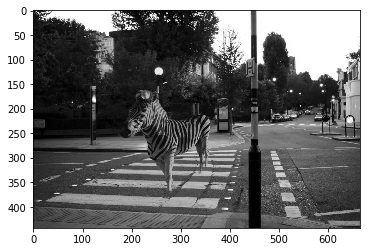

In [13]:
plt.imshow(input_image, cmap=plt.get_cmap('gray'))

## Gaussian Filter

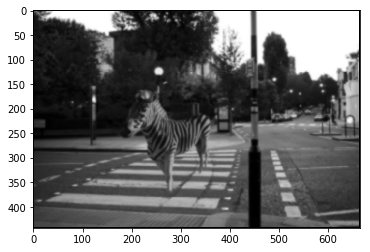

In [14]:
plt.imshow(gaussian_output, cmap=plt.get_cmap('gray'))

## Gradient X

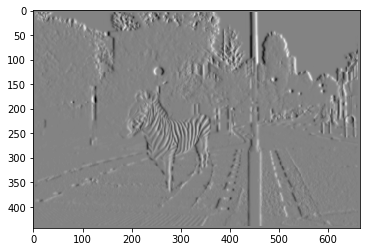

In [15]:
plt.imshow(prewittx_output, cmap=plt.get_cmap('gray'))

## Gradient Y

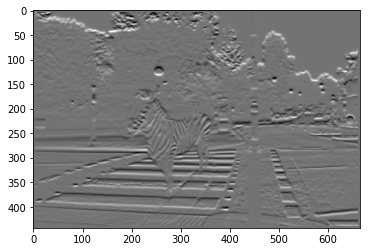

In [16]:
plt.imshow(prewitty_output, cmap=plt.get_cmap('gray'))

## Edge Magnitude

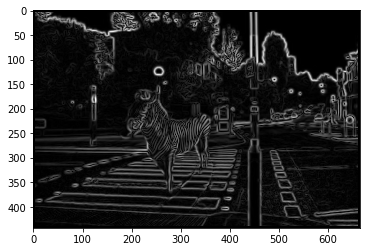

In [17]:
plt.imshow(edgemagnitude_output, cmap=plt.get_cmap('gray'))

## Non Maxima Suppression

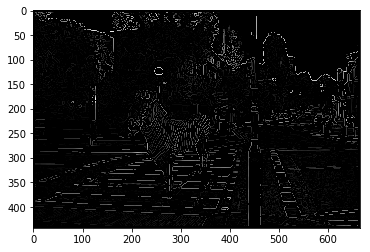

In [18]:
plt.imshow(nms_output, cmap=plt.get_cmap('gray'))

## P = 10%

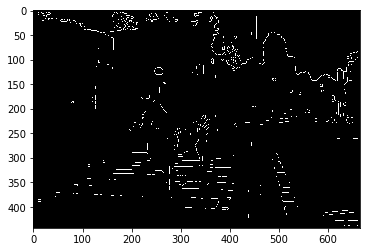

In [19]:
plt.imshow(Q10_final_output, cmap=plt.get_cmap('gray'))

## P = 30%

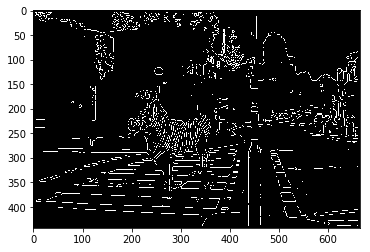

In [20]:
plt.imshow(Q30_final_output, cmap=plt.get_cmap('gray'))

## P = 50%

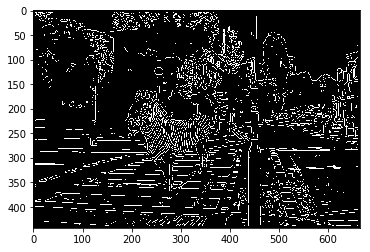

In [21]:
plt.imshow(Q50_final_output, cmap=plt.get_cmap('gray'))

## Check the current working directory for clear output images:

In [22]:
import os
os.getcwd()

'C:\\Users\\rakav\\Desktop\\Fall 2018\\CV\\project1\\ra2635_project1'